In [1]:
# Import statements
from brian2 import *

In [2]:
# Parameter definition
# Simulation
duration = 2*second
defaultclock.dt = 1*ms

# Oscillators
seed(42)
sync = [1, 5, 10, 15, 20, 25, 30, 40, 50, 100]
N = [250]*len(sync)
sync_v = np.array([])
for idx in range(len(N)):
    sync_v = np.concatenate((sync_v, np.repeat(sync[idx],N[idx])))
f0 = 4 # center freq [Hz]
sigma = 0.5 # normal std offset for omega

# Input stim
dt_stim = 1*ms
t_stim = 1.5*second
stim_dur = 100*ms
I0 = 0
tv = linspace(0, duration/second, int(duration/(dt_stim))+1)
xstim = 1. * logical_and(tv>t_stim/second, tv<(t_stim+stim_dur)/second)
pulse_train = TimedArray(xstim, dt=dt_stim)

In [3]:
# Equations
# Kuramoto oscillators
kuramoto_eqs = '''
    dTheta/dt = ((omega + (kN * PIF) - I_stim*X*sin(Theta + offset)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    
    ThetaPreInput : 1
    omega : 1 (constant)
    kN : 1 # k/N ratio, affects sync.
    offset : 1 (shared) # range [0, 2*pi], controls phase reset curve
    I_stim : 1 (shared) # this is the input gain, affects the phase reset aggressiveness
    X = pulse_train(t) : 1 (shared)
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter group calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    test = y : 1
    rhythm_pos = coherence * (sin(phase)+1)/2 : 1
    rhythm_rect = rhythm_pos*nA : amp
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [4]:
# Make the necessary groups
# Oscillators
N_tot = sum(N)
G_K = NeuronGroup(N_tot,
    model=kuramoto_eqs,
    threshold='True',
    method='euler',
    name='Kuramoto_oscillators_N_%d' % N_tot)
#G_K.Theta = '2*pi*rand()' # uniform U~[0,2π]
#G_K.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
theta0 = 2*pi*rand(N_tot) # uniform U~[0,2π]
omega0 = 2*pi*(f0 + sigma*randn(N_tot)) # ~N(2πf0,σ)
G_K.Theta = theta0
G_K.omega = omega0
G_K.offset = 0.*np.pi
G_K.kN = sync_v
G_K.I_stim = I0

# Kuramoto order parameter group
G_pop_avg = NeuronGroup(len(N),
    model=pop_avg_eqs,
    #method='euler',
    name='Kuramoto_averaging')

print('General groups: done')

General groups: done


In [5]:
# Define subgroups
G_all = []
syn_all = []

kuramoto_mon_all = []
order_param_mon_all = []

idx0 = 0
idx1 = 0

for gnum in range(len(N)):
    N_curr = N[gnum]
    
    idx0 = idx1
    idx1 += N_curr
    
    # Subgroups
    G_K_curr = G_K[idx0:idx1]
    
    G_pop_avg_curr = G_pop_avg[gnum]
    r0 = 1/N_curr * sum(exp(1j*G_K_curr.Theta))
    G_pop_avg_curr.x = real(r0)  # avoid division by zero
    G_pop_avg_curr.y = imag(r0)
    
    G_all.append(G_K_curr)
    G_all.append(G_pop_avg_curr)
    
    
    # Synapses
    syn_kuramoto_curr =  Synapses(G_K_curr, G_K_curr, on_pre=syn_kuramoto_eqs, method='euler', name='Kuramoto_intra_{0}'.format(gnum))
    syn_kuramoto_curr.connect(condition='i!=j')

    syn_avg_curr = Synapses(G_K_curr, G_pop_avg_curr, syn_avg_eqs, name='Kuramoto_avg_{0}'.format(gnum))
    syn_avg_curr.connect()
    
    syn_all.append(syn_kuramoto_curr)
    syn_all.append(syn_avg_curr)

    
    # Monitors
    kuramoto_mon_curr = StateMonitor(G_K_curr, ['Theta'], record=True)
    order_param_mon_curr = StateMonitor(G_pop_avg_curr, ['coherence', 'test', 'phase', 'rhythm', 'rhythm_pos', 'rhythm_rect'], record=True)
    
    kuramoto_mon_all.append(kuramoto_mon_curr)
    order_param_mon_all.append(order_param_mon_curr)
    
print('Subgroups: done')

Subgroups: done


In [6]:
# Network
net = Network()
net.add(G_K)
net.add(G_pop_avg)
net.add(G_all)
net.add(syn_all)
net.add(kuramoto_mon_all)
net.add(order_param_mon_all)

In [7]:
# Run the simulation
net.run(duration, report='text', report_period=10*second, profile=True)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the 

Starting simulation at t=0. s for a duration of 2. s
2. s (100%) simulated in 2s


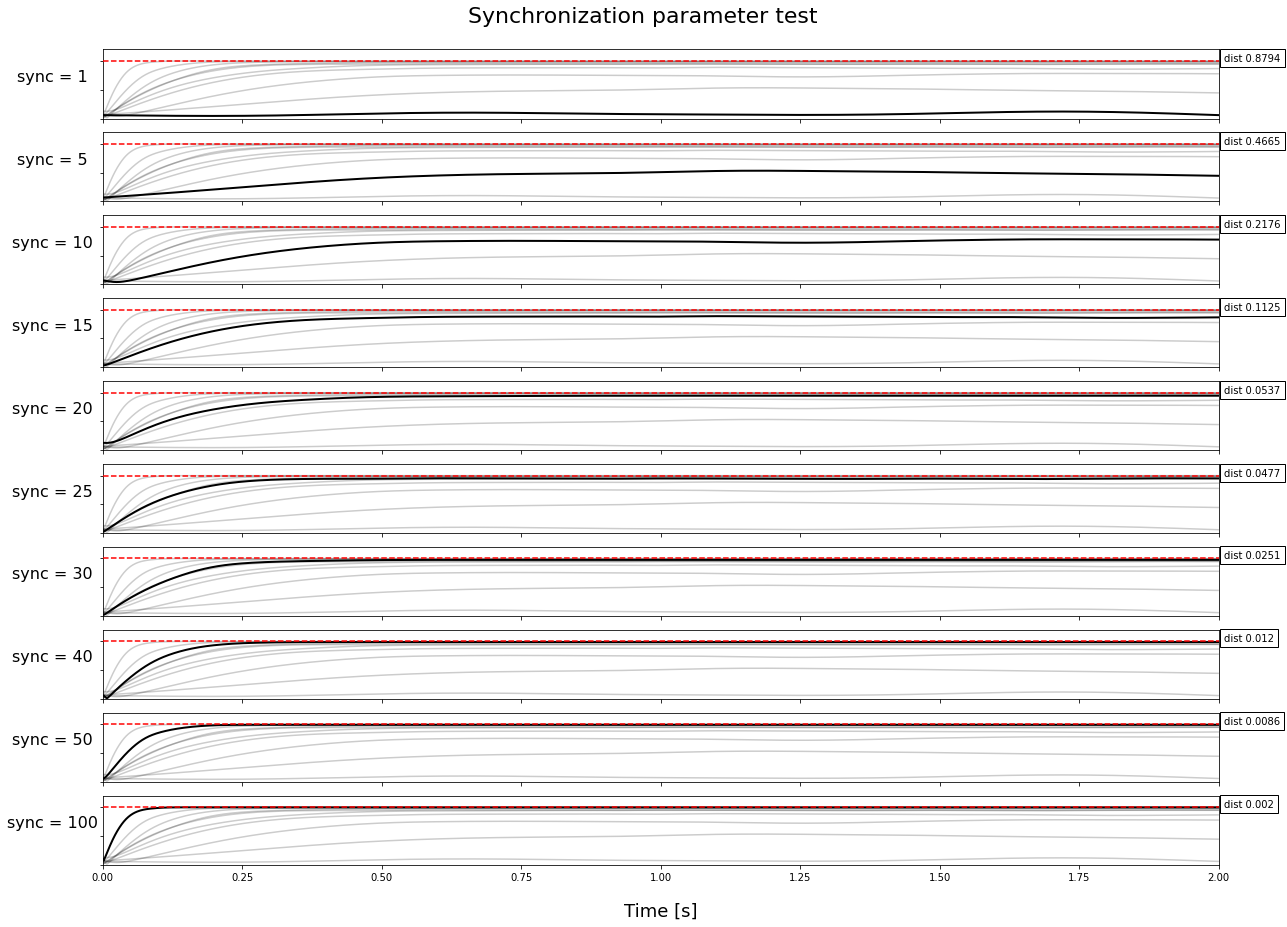

In [9]:
# Avoiding chartjunk [Bottom subplot]
fig, axs = subplots(len(sync), figsize=(20,15))

fig.suptitle('Synchronization parameter test', fontsize=22, y=0.92)

for axnum in range(len(sync)):
    for gnum in range(len(sync)):
        if axnum == gnum:
            #axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
            lab = round(1.-max(order_param_mon_all[gnum].coherence[0]),4)
            axs[axnum].text(duration+10*ms, 1., "dist "+str(lab), bbox=dict(facecolor='white'))
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', linewidth=2, c='k', alpha=1, zorder=3)
        else:
            #axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].rhythm_pos[0], ls='-', c='k', alpha=0.2, zorder=2)
            axs[axnum].plot(order_param_mon_all[gnum].t/second, order_param_mon_all[gnum].coherence[0], ls='-', c='k', alpha=0.2, zorder=2)

    axs[axnum].set_ylim([0,1.2])
    axs[axnum].set_xlim([0,duration])
    axs[axnum].tick_params(axis='both',       # changes apply to both axes
                           which='both',      # both major and minor ticks are affected
                           bottom=True,       # ticks along the bottom edge are on
                           top=False,         # ticks along the top edge are on
                           right=False, 
                           left=True, 
                           labelbottom=False, # labels along the bottom edge are off
                           labelleft=False)
    axs[axnum].set_ylabel('sync = %d' % sync[axnum], fontsize=16, rotation=0, labelpad=50)

    if I0:
        vline = axs[axnum].axvline(x=t_stim/second, ymin=-1, ymax=1, c="red", linewidth=1.5, zorder=3, clip_on=False)
    hline = axs[axnum].axhline(y=1., c='red', ls='--', linewidth=1.5, zorder=3)

axs[axnum].set_xlabel('Time [s]', fontsize=18, labelpad=20)
axs[axnum].tick_params(axis='x',
                       which='both',
                       bottom=True,
                       top=False,
                       right=False,
                       left=True,
                       labelbottom=True,
                       labelleft=False)
# clip the last vline
#vline.set(clip_on=True)

fig.savefig('Sync Parameter Test.png', facecolor='white', transparent=False)
plt.show()